# CapStone Project

#### This project will try to create a convolution Neural network, train it with Street view house numbers and calculate the accuracy of predicting of house numbers 

Data set 
http://ufldl.stanford.edu/housenumbers/

##### For visualization of the house numbers images you can have a look at the site provided above

In [2]:
import tensorflow as tf
import scipy.io as scp
import numpy as np
import random
from scipy import misc
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data 
testData = scp.loadmat('../../data/svhn/test_32x32.mat')
trainData = scp.loadmat('../../data/svhn/train_32x32.mat')

logs_path = '/home/ubuntu/tensorFlowLogs/'

In [3]:
testDataX = testData['X'].astype('float32') / 128.0 - 1         
testDataY = testData['y']

trainDataX = trainData['X'].astype('float32') / 128.0 - 1
trainDataY = trainData['y']

In [4]:
print type(trainDataX)
print type(trainDataY)

print 'train Data image shape : ', trainDataX.shape
print 'train data output shape : ', trainDataY.shape
print 'test data image shape : ', testDataX.shape
print 'test data output shape : ', testDataY.shape

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
train Data image shape :  (32, 32, 3, 73257)
train data output shape :  (73257, 1)
test data image shape :  (32, 32, 3, 26032)
test data output shape :  (26032, 1)


In [5]:
# try tansposing the array
def transposeArray(data):
    xtrain = []
    trainLen = data.shape[3]
    for x in xrange(trainLen):
        xtrain.append(data[:,:,:,x])
    
    xtrain = np.asarray(xtrain)
    return xtrain

In [6]:
trainDataX = transposeArray(trainDataX)
testDataX = transposeArray(testDataX)


print 'New train data image shape : ', trainDataX.shape

New train data image shape :  (73257, 32, 32, 3)


In [7]:
def OnehotEndoding(Y):
    Ytr=[]
    for el in Y:
        temp=np.zeros(10)
        if el==10:
            temp[0]=1
        elif el==1:
            temp[1]=1
        elif el==2:
            temp[2]=1
        elif el==3:
            temp[3]=1
        elif el==4:
            temp[4]=1
        elif el==5:
            temp[5]=1
        elif el==6:
            temp[6]=1
        elif el==7:
            temp[7]=1
        elif el==8:
            temp[8]=1
        elif el==9:
            temp[9]=1
        Ytr.append(temp)
        
    return np.asarray(Ytr)

##### Converting the label to one hot encoding as the prediction really improves. This make sense as well. 

In [8]:
# convert y to one hot encoding
trainDataY = OnehotEndoding(trainDataY)
testDataY = OnehotEndoding(testDataY)
print 'train data output shape : ', trainDataY.shape
print 'test data output shape : ', testDataY.shape

train data output shape :  (73257, 10)
test data output shape :  (26032, 10)


In [9]:
#Neural network parameters
height = 32
width = 32
channel = 3
tags = 10
patch = 5
depth = 16
num_hidden = 128
dropout = 0.75 # Dropout, probability to keep units

learning_rate = 1e-4

In [10]:
stddev = 1e-1
tf_X = tf.placeholder("float", shape=[None, height, width, channel], name = "X-Input")
tf_Y = tf.placeholder("float", shape=[None, tags], name = "LabeledData")

convW1 = tf.Variable(tf.random_normal([patch, patch, channel, depth], stddev=stddev), name="ConvW1")
bias1 = tf.Variable(tf.random_normal([depth], stddev=stddev), name="Bias1")

convW2 = tf.Variable(tf.random_normal([patch, patch, depth, depth], stddev=stddev), name="ConvW2")
bias2 = tf.Variable(tf.random_normal([depth], stddev=stddev), name = "Bias2")

w3 = tf.Variable(tf.random_normal([height // 4 * width // 4 * depth, num_hidden], stddev=stddev), name="w3")
bias3 = tf.Variable(tf.random_normal([num_hidden]), name="bias3")

w4 = tf.Variable(tf.random_normal([num_hidden, tags], stddev=stddev), name="w4")
bias4 = tf.Variable(tf.random_normal([tags], stddev=stddev), name="bias4")  

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


### Here is the model I have tried to build
Input Image : 32x32x3
first Convolution Hidden layer : 5x5x3x16
Padding : Same, Stride : [1,2,2,1]
Output of first Convolution Hidden layer : 16x16x16

Second Convolution Hidden layer : 5x5x16x16
Padding : Same, Stride : [1,2,2,1]
Output of Second Convolution Hidden layer : 8x8x16

third Hidden Layer fully connected : 8x8x16
Output of third Hidden layer : 64

Fourth Hidden Layer : 64 x 10

In [11]:
#model

def model(X):
    
    #first layer : Convolution
    conv = tf.nn.conv2d(X, convW1, [1,1,1,1], padding='SAME')
    hidden1 = tf.nn.relu(conv + bias1)
    
    #second layer : pooling
    hidden2 = tf.nn.max_pool(hidden1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    #third layer : convolution
    conv2 = tf.nn.conv2d(hidden2, convW2, [1,1,1,1], padding='SAME')
    hidden3 = tf.nn.relu(conv2 + bias2)
    
    #fourth layer : pooling
    hidden4 = tf.nn.max_pool(hidden3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    #reshape it to a single Dimensional
    shape = hidden4.get_shape()
    
    #5th layer : fully connected
    newInput = tf.reshape(hidden4, [-1, shape[1].value * shape[2].value * shape[3].value])
    hidden5 = tf.nn.relu(tf.matmul(newInput, w3) + bias3)
    
    dp5 = tf.nn.dropout(hidden5, keep_prob)
    
    return tf.matmul(dp5, w4) + bias4

In [12]:
with tf.name_scope('Model'):
    pred = model(tf_X)
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, tf_Y))


# Optimizer.
with tf.name_scope('AdamOptimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(tf.nn.softmax(pred),1),tf.argmax(tf_Y,1)), "float"))
    
# Create a summary to monitor cost tensor
tf.scalar_summary("loss", loss)
# Create a summary to monitor accuracy tensor
tf.scalar_summary("accuracy", accuracy)
# Merge all summaries into a single op
merged_summary_op = tf.merge_all_summaries()

In [13]:
def Accuracy(X, Y, message, sess):    
    print message, sess.run(accuracy, feed_dict= {tf_X: X, tf_Y: Y, keep_prob:1.0})

###### Ran the model with epoch 50000 and batch size of 128. Received accuracy of around 89% on the test data
###### Could not run the accuracy on the training set as I was getting OOM exceptions. The training data is huge so cannot run on my 8 core machine. Please refer to the "convHouse.log" file for correct accuracy.

In [ ]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())
    
    epoch = 50000
    batch_size = 128
    print('Initialized')
    
    p = np.random.permutation(range(len(trainDataX)))
    trX, trY = trainDataX[p], trainDataY[p]
    start = 0
    end = 0
    
    for step in range(epoch):
        start = end
        end = start + batch_size
        
        if start >= len(trainDataX):
            start = 0
            end = start + batch_size
            
        if end >= len(trainDataX):
            end = len(trainDataX) - 1
        if start == end:
            start = 0
            end = start + batch_size
        
        #print step, start, end
            
        #batch = np.random.choice(len(trainDataX) - 1, batch_size)
        inX, outY = trX[start:end], trY[start:end]
        _, summary = sess.run([optimizer, merged_summary_op], feed_dict= {tf_X: inX, tf_Y: outY, keep_prob:0.75})
        summary_writer.add_summary(summary, step)
        
        if step % 500 == 0:
            print 'cost at each step :', step, 'is :', sess.run(loss, feed_dict={tf_X: inX, tf_Y: outY, keep_prob:1.0})
    
    #Accuracy(trX, trY, 'accuracy of training data : ', sess)
    Accuracy(testDataX, testDataY, 'accuracy of test data : ', sess)

####  Below figures show the growth of loss and accuracy. Loss decreases with step size and accuracu increases with step size

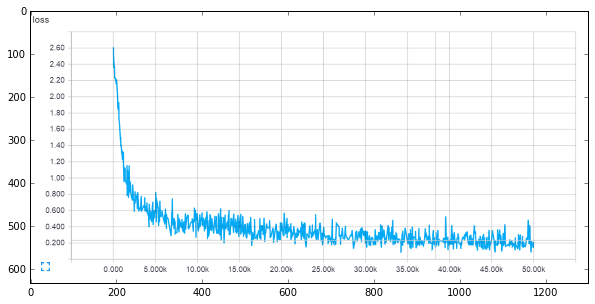

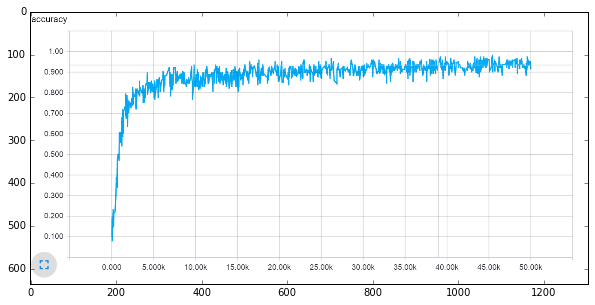

In [21]:
fig = plt.figure(figsize=(10,10))
lossImg = misc.imread('loss.PNG')
accuracyImg = misc.imread('accuracy.PNG')

plt.imshow(lossImg)
plt.show()

fig = plt.figure(figsize=(10,10))
plt.imshow(accuracyImg)
plt.show()

Initialized
cost at each step : 0 is : 2.6576
cost at each step : 500 is : 1.92077
cost at each step : 1000 is : 1.37282
cost at each step : 1500 is : 0.870127
cost at each step : 2000 is : 0.711635
cost at each step : 2500 is : 0.486733
cost at each step : 3000 is : 0.630811
cost at each step : 3500 is : 0.612623
cost at each step : 4000 is : 0.689234
cost at each step : 4500 is : 0.424147
cost at each step : 5000 is : 0.561107
cost at each step : 5500 is : 0.625011
cost at each step : 6000 is : 0.448621
cost at each step : 6500 is : 0.482624
cost at each step : 7000 is : 0.473487
cost at each step : 7500 is : 0.356364
cost at each step : 8000 is : 0.498098
cost at each step : 8500 is : 0.281976
cost at each step : 9000 is : 0.357416
cost at each step : 9500 is : 0.252303
cost at each step : 10000 is : 0.497836
cost at each step : 10500 is : 0.449012
cost at each step : 11000 is : 0.358522
cost at each step : 11500 is : 0.285492
cost at each step : 12000 is : 0.395516
cost at each step : 12500 is : 0.25675
cost at each step : 13000 is : 0.311785
cost at each step : 13500 is : 0.346169
cost at each step : 14000 is : 0.426077
cost at each step : 14500 is : 0.272177
cost at each step : 15000 is : 0.30715
cost at each step : 15500 is : 0.30222
cost at each step : 16000 is : 0.290662
cost at each step : 16500 is : 0.258701
cost at each step : 17000 is : 0.294812
cost at each step : 17500 is : 0.277403
cost at each step : 18000 is : 0.365175
cost at each step : 18500 is : 0.275363
cost at each step : 19000 is : 0.307067
cost at each step : 19500 is : 0.267246
cost at each step : 20000 is : 0.240689
cost at each step : 20500 is : 0.275802
cost at each step : 21000 is : 0.181096
cost at each step : 21500 is : 0.2127
cost at each step : 22000 is : 0.237906
cost at each step : 22500 is : 0.462042
cost at each step : 23000 is : 0.256202
cost at each step : 23500 is : 0.415456
cost at each step : 24000 is : 0.36995
cost at each step : 24500 is : 0.317184
cost at each step : 25000 is : 0.254055
cost at each step : 25500 is : 0.350063
cost at each step : 26000 is : 0.158022
cost at each step : 26500 is : 0.29065
cost at each step : 27000 is : 0.184727
cost at each step : 27500 is : 0.217466
cost at each step : 28000 is : 0.159578
cost at each step : 28500 is : 0.306664
cost at each step : 29000 is : 0.162781
cost at each step : 29500 is : 0.206243
cost at each step : 30000 is : 0.187358
cost at each step : 30500 is : 0.283236
cost at each step : 31000 is : 0.184029
cost at each step : 31500 is : 0.366909
cost at each step : 32000 is : 0.169825
cost at each step : 32500 is : 0.175509
cost at each step : 33000 is : 0.196755
cost at each step : 33500 is : 0.195132
cost at each step : 34000 is : 0.185456
cost at each step : 34500 is : 0.175545
cost at each step : 35000 is : 0.176949
cost at each step : 35500 is : 0.14594
cost at each step : 36000 is : 0.33098
cost at each step : 36500 is : 0.197402
cost at each step : 37000 is : 0.290938
cost at each step : 37500 is : 0.298807
cost at each step : 38000 is : 0.261421
cost at each step : 38500 is : 0.19854
cost at each step : 39000 is : 0.115448
cost at each step : 39500 is : 0.198216
cost at each step : 40000 is : 0.126958
cost at each step : 40500 is : 0.167211
cost at each step : 41000 is : 0.149497
cost at each step : 41500 is : 0.137184
cost at each step : 42000 is : 0.2285
cost at each step : 42500 is : 0.163846
cost at each step : 43000 is : 0.0905895
cost at each step : 43500 is : 0.121242
cost at each step : 44000 is : 0.170001
cost at each step : 44500 is : 0.148984
cost at each step : 45000 is : 0.144387
cost at each step : 45500 is : 0.13648
cost at each step : 46000 is : 0.100441
cost at each step : 46500 is : 0.124121
cost at each step : 47000 is : 0.138372
cost at each step : 47500 is : 0.326166
cost at each step : 48000 is : 0.231229
cost at each step : 48500 is : 0.182549
cost at each step : 49000 is : 0.0651341
cost at each step : 49500 is : 0.190509
accuracy of test data :  0.894822